<a href="https://colab.research.google.com/github/dkgithub/wiehl24/blob/main/skorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Working with PyTorch can become involved. There are many tool that try to avoid writimg out all the litlle details.
Most commonly used is lighning. Here, we use skorch. It provides a Keras like interface that interacts smoothly with sklearn.

In [136]:
#!rm -rf helpers # if an enforced reinstall is necessary
![ ! -d helpers ] && git clone --recursive https://github.com/dkgithub/erum_ml_school_helpers helpers
!pip install wget

Cloning into 'helpers'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 53 (delta 28), reused 32 (delta 13), pack-reused 0
Receiving objects: 100% (53/53), 13.22 KiB | 6.61 MiB/s, done.
Resolving deltas: 100% (28/28), done.


In [137]:
!pip install wget torchinfo skorch

In [138]:
# load the helpers package and other software
import helpers as hlp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torchinfo

In [139]:
#check for accelerators
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('torch',torch.__version__)
print('device type is',device)
if device == 'cuda' :print(torch.cuda.get_device_name())
from os import environ
if "COLAB_TPU_ADDR" in environ and environ["COLAB_TPU_ADDR"]:
  print("A TPU is connected.")


torch 2.1.0+cu121
device type is cpu


In [140]:
# first, we define a preprocessing function that (e.g.) takes the
# constiuents and returns another representation of them

#def preprocess_constituents(constituents):
#    return constituents[:, :120].reshape((-1, 480))

def preprocess_constituents(constituents):
  # sum all constituents to get jet 4-momenta
  c_sum=constituents.sum(axis=1)
  metric=np.array([1.,-1.,-1.,-1.]) #g_mu_nu
  # calculating invariants wrt. to jet
  c_inv=(constituents*metric*c_sum[:,None,:]).sum(axis=2)
  return c_inv



In [141]:
def getData(name=None,nFiles=None):
  if name not in ['train','valid','test']:
    print(f'Need a proper data split name')
    return
  if name == 'train' and nFiles == None: nFiles = 2
  else: nFiles = 1
  c_vectors, _, labels = hlp.data.load(name, stop_file=nFiles)
  # run the preprocessing
  c_vectors = preprocess_constituents(c_vectors)
  # create torch tensors from numpy arrays, map to float32,
  c_tensor      = torch.from_numpy(c_vectors).float()
  label_tensor  = torch.from_numpy(labels   ).float()
  print(f'Data {name} - length \t{len(c_tensor)} \tshape {c_tensor.shape}' )
  return c_tensor,label_tensor


In [142]:
data_train, label_train = getData('train')
data_valid, label_valid = getData('valid')
data_test,  label_test  = getData('test')


Data train - length 	100000 	shape torch.Size([100000, 200])
Data valid - length 	50000 	shape torch.Size([50000, 200])
Data test - length 	50000 	shape torch.Size([50000, 200])


In [143]:
# here, we define a function to construct the datasets
def makeDataset(name=None,nFiles=None):
  if name not in ['train','valid','test']:
    print(f'Need a proper data split name')
    return
  if name == 'train' and nFiles == None: nFiles = 2
  else: nFiles = 1
  c_vectors, _, labels = hlp.data.load(name, stop_file=nFiles)
  # run the preprocessing
  c_vectors = preprocess_constituents(c_vectors)
  # create torch tensors from numpy arrays, map to float32,
  # and move to GPU if available - device must be defined
  c_tensor      = torch.from_numpy(c_vectors).float()
  label_tensor  = torch.from_numpy(labels   ).float()
  # Then, we create a dataset from our tensors
  print(f'dataset {name} \tlength',len(label_tensor),'\tshape',c_tensor.shape)
  return torch.utils.data.TensorDataset(c_tensor,label_tensor)

In [62]:
ds_train = makeDataset('train')
ds_valid = makeDataset('valid')
ds_test  = makeDataset('test')

dataset train 	length 100000 	shape torch.Size([100000, 200])
dataset valid 	length 50000 	shape torch.Size([50000, 200])
dataset test 	length 50000 	shape torch.Size([50000, 200])


Skorch works with callbacks. Callbacks are called at certain points in the processing loop. Especially: epoch start,epoch end, batch start and batch end. Most common callbacks, e.g. scoring are predefined.

In [44]:
from skorch.callbacks import EpochScoring,EpochTimer
auc = EpochScoring(scoring='roc_auc',  lower_is_better=False)
acc = EpochScoring(scoring='accuracy', lower_is_better=False)

Skorch likes to create train and valid split internally but we already have our data splitted. There is a helper function for this situation

In [85]:
from skorch.helper import predefined_split

In [63]:
# we construct a network
from torch import nn
class myModel(nn.Module):
  def __init__(self,in_size=200,mid_size=200,n_layers=5):
    super().__init__()
    self.in_size  = in_size
    self.mid_size = mid_size
    self.n_layers = n_layers
    self.inLay    = nn.Linear(in_size,mid_size)
    self.linears  = nn.ModuleList([nn.Linear(mid_size, mid_size) for i in range(n_layers)])
    self.bnorms   = nn.ModuleList([nn.BatchNorm1d(mid_size) for i in range(n_layers)])
    self.outLay   = nn.Linear(mid_size, 1)

  def forward(self, x):
    x = self.inLay(x)
    x = torch.relu(x)
    # ModuleList can act as an iterable, or be indexed using ints
    for i,lay in enumerate(self.linears):
      x = lay(x)
      self.bnorms[i](x)
      x = torch.relu(x)
    x = self.outLay(x)
    x = torch.sigmoid(x)
    return x

# we initiate the model
model=myModel()

Now, we can define our classifier and fit==train it.

In [89]:
from skorch import NeuralNetClassifier
net = NeuralNetClassifier(
    model,
    criterion=nn.BCELoss,
    optimizer=torch.optim.Adam,
    lr=0.01,
    batch_size=500,
    max_epochs=10,
    callbacks=[acc,auc],
    train_split=predefined_split(ds_valid),
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    #callbacks=[LivePlot],
    device=device
)

In [90]:
net.fit(ds_train, ds_train.tensors[1])

  epoch    accuracy    roc_auc    train_loss    valid_acc    valid_loss     dur
-------  ----------  ---------  ------------  -----------  ------------  ------
      1      0.8961     0.9401        0.9681       0.8961        0.2777  6.4402
      2      0.8971     0.9505        0.2713       0.8971        0.2578  6.0509
      3      0.8922     0.9403        0.2642       0.8922        0.2760  6.7347
      4      0.8975     0.9526        0.2619       0.8975        0.2541  6.4767
      5      0.8966     0.9513        0.2617       0.8966        0.2558  7.6540
      6      0.8969     0.9523        0.2592       0.8969        0.2558  6.4165
      7      0.8965     0.9517        0.2601       0.8965        0.2603  7.5025
      8      0.8971     0.9514        0.2559       0.8971        0.2574  7.1154
      9      0.8944     0.9525        0.2576       0.8944        0.2617  7.6174
     10      0.8955     0.9500        0.2596       0.8955        0.2605  7.1644


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=myModel(
    (inLay): Linear(in_features=200, out_features=200, bias=True)
    (linears): ModuleList(
      (0-4): 5 x Linear(in_features=200, out_features=200, bias=True)
    )
    (bnorms): ModuleList(
      (0-4): 5 x BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (outLay): Linear(in_features=200, out_features=1, bias=True)
  ),
)

In [134]:
def plotLearningCurvesSkorch(history,start=0,stop=None):
  """
  Usage plotLearningCurvesSkorch(history) with skorch net.history object
        plotLearningCurvesSkorch(history,start)
        plotLearningCurvesSkorch(history,start,stop)

  """
  if stop==None:stop=len(history)
  plt.figure(figsize=(10,5))
  # losses
  plt.subplot(1,2,1)
  plt.plot(history[start:stop,'train_loss'])
  plt.plot(history[start:stop,'valid_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train','validation'], loc='upper right')
  # accuracy plot
  plt.subplot(1,2,2)
  plt.plot(history[start:stop,'accuracy'])
  plt.plot(history[start:stop,'valid_acc'])
  plt.legend(['train','validation'], loc='lower right')
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.show()
  minValid = np.argmin(history[:,'valid_loss'])
  minTrain = np.argmin(history[:,'train_loss'])
  maxAcc   = np.argmax(history[:,'valid_acc'])
  print(f"min train loss {history[:,'train_loss'][minTrain]:5.3f} at ep. {minTrain}")
  print(f"min valid loss {history[:,'valid_loss'][minValid]:5.3f} at ep. {minValid}")
  print(f"best valid accurracy {history[:,'accuracy'][maxAcc]:6.2f} at ep. {maxAcc}")

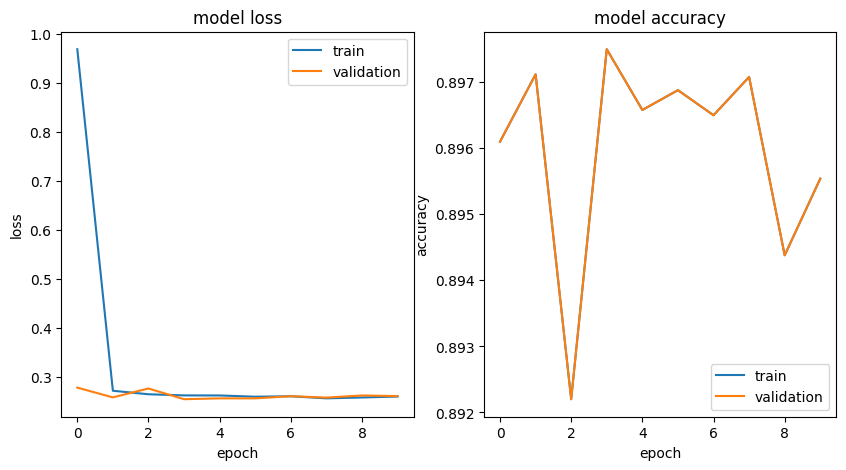

min train loss 0.256 at ep. 7
min valid loss 0.254 at ep. 3
best valid accurracy   0.90 at ep. 3


In [135]:
plotLearningCurvesSkorch(net.history)

In [133]:
minTrain=np.argmin(net.history[:,'train_loss'])
net.history[:,'train_loss'][minTrain]

0.25587631434202196

In [120]:
net.history


[{'batches': [{'train_loss': 0.24301782250404358, 'train_batch_size': 500},
   {'train_loss': 44.71316909790039, 'train_batch_size': 500},
   {'train_loss': 39.586448669433594, 'train_batch_size': 500},
   {'train_loss': 6.701833724975586, 'train_batch_size': 500},
   {'train_loss': 16.559534072875977, 'train_batch_size': 500},
   {'train_loss': 2.5937693119049072, 'train_batch_size': 500},
   {'train_loss': 8.772834777832031, 'train_batch_size': 500},
   {'train_loss': 0.6435942053794861, 'train_batch_size': 500},
   {'train_loss': 1.0241538286209106, 'train_batch_size': 500},
   {'train_loss': 5.389644622802734, 'train_batch_size': 500},
   {'train_loss': 0.5864344835281372, 'train_batch_size': 500},
   {'train_loss': 0.6726036667823792, 'train_batch_size': 500},
   {'train_loss': 0.5519452691078186, 'train_batch_size': 500},
   {'train_loss': 0.4028235673904419, 'train_batch_size': 500},
   {'train_loss': 1.47202467918396, 'train_batch_size': 500},
   {'train_loss': 0.51923602819442